# Implementing Neural Network Training with Different Optimizers

### Objective:
The goal of this assignment is to implement a small neural network from scratch and train it using three different optimization algorithms: Stochastic Gradient Descent (SGD), SGD with Momentum, and SGD with AdaGrad. You will need to compare the performance of these optimizers.

## 1- Dataset

### Digits

This dataset, sourced from sklearn, consists of 1797 images, each sized 8x8 pixels. Every image, like the example shown below, depicts a handwritten digit. To utilize an 8x8 image, it must first be transformed into a feature vector of length 64.

The task with this dataset is to classify each digit, with a total of 10 classes.

The targets are one-hot encoded, i.e. each digit is transformed into a 10-dimensional vector with the element corresponding to the digit set to 1, and the other elements set to 0.

dataset's dimensions: (1797, 64)


<Figure size 640x480 with 0 Axes>

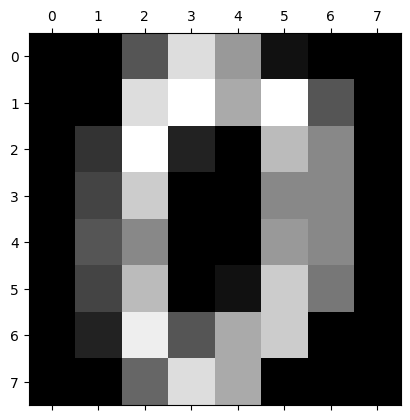

In [3]:
import matplotlib.pyplot as plt
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
import numpy as np

digits = load_digits()
print("dataset's dimensions:", digits.data.shape)
plt.gray()
plt.matshow(digits.images[0])
plt.show()


In [4]:
# this function loads train and test sets from digits dataset
def load_data():
    digits = load_digits()
    X = digits.data
    y = digits.target

    enc = OneHotEncoder()
    y = enc.fit_transform(y.reshape(-1, 1)).toarray()

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    return X_train, y_train, X_test, y_test

## 2- Neural Network Architecture:
* Implement a simple feedforward neural network with one hidden layer.
* Use sigmoid activation for the hidden layer and softmax for the output layer.
* Feel free to add any necessary functions to the class below.
* See figure 2 in assignment pdf for a diagram

In [6]:
# Neural network forward and backward propagation
class NeuralNetwork:
    def __init__(self, input_size, hidden_size, output_size):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, hidden_size) * 0.01
        self.b1 = np.zeros((1, hidden_size))
        self.W2 = np.random.randn(hidden_size, output_size) * 0.01
        self.b2 = np.zeros((1, output_size))

        self.dW1 = np.zeros((input_size, hidden_size))
        self.db1 = np.zeros((1, hidden_size))
        self.dW2 = np.zeros((hidden_size, output_size))
        self.db2 = np.zeros((1, output_size))

    # helper functions for our activations
    def sigmoid_derivative(self, x):
        y = self.sigmoid(x)
        return y * (1 - y)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax_derivative(self, x):
        y = self.softmax(x)
        
        def jac(row):
            sm = row.reshape((-1, 1))
            sm_dot = np.einsum('ij,jk->ik', sm, sm.T)
            return np.diagflat(row) - sm_dot
            
        d = np.apply_along_axis(jac, axis=1, arr=y)
        return d

    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # forward and backward functions
    def forward(self, X):
        # Implement forward pass
        # You should store the intermediate values as fields to be used by the backward pass
        # The forward pass must work for all batch sizes

        # X: the x values, batched along dimension zero
        # return: z2

        self.a1 = np.dot(X, self.W1) + self.b1
        self.z1 = self.sigmoid(self.a1)
        self.a2 = np.dot(self.z1, self.W2) + self.b2
        self.z2 = self.softmax(self.a2)
        return self.z2

    def backward(self, X, y):
        # Implement backward pass, assuming the MSE loss (see section 3 for clarification)
        # Use the intermediate values calculated from the forward pass,
        # and store the gradients in fields
        # The backward pass must also work for all batch sizes

        # X: the x values, batched along dimension zero
        # y: batched target values
        # return: None

        batch_size = X.shape[0]
        dz2 = (2 * (self.z2 - y) / batch_size)
        
        delta2 = np.einsum('Bi,BNi->BN', dz2, self.softmax_derivative(self.a2))
        self.dW2 = np.dot(self.z1.T, delta2)
        self.db2 = np.sum(delta2, axis=0, keepdims=True)

        delta1 = np.dot(delta2, self.W2.T) * self.sigmoid_derivative(self.a1)
        self.dW1 = np.dot(X.T, delta1)
        self.db1 = np.sum(delta1, axis=0, keepdims=True)

    def get_params_and_grads(self):
        # Return parameters and corresponding gradients
        params = [self.W1, self.b1, self.W2, self.b2]
        grads = [self.dW1, self.db1, self.dW2, self.db2]
        return params, grads


## 3- Helper Functions
Implement the following helper functions (the `plot_all_results` function is already implemented):

* `mean_squared_error(predictions, targets)`: This function receives the predicted values from the network and the target values, calculates the mean squared loss, and returns the loss value. For clarification, you should take the mean of the squared error over the samples in the batch, and *not* over the outputs of each sample

* `compute_accuracy(predictions, targets)`: This function receives the predicted values and the target values, and returns the accuracy of the predictions. The predicted value is the index with the highest network output (z2) value.

* Feel free to add any other necessary helper functions here.


In [7]:
def mean_squared_error(predictions, targets):
    # Returns MSE loss
    mse = np.mean(np.square(predictions - targets))
    return mse

def compute_accuracy(predictions, targets):
    # Returns the accuracy of the predicted labels (between 0 and 1)
    predicted_labels = np.argmax(predictions, axis=1)
    true_labels = np.argmax(targets, axis=1)
    accuracy = np.mean(predicted_labels == true_labels)
    return accuracy

def plot_all_results(all_losses, all_accuracies, all_labels):
    if len(all_losses) != len(all_accuracies):
      raise ValueError("all_losses length must be equal to all_accuracies length")

    if len(all_losses) != len(all_labels):
      raise ValueError("all_labels length must be equal to all_losses length")

    epochs = len(all_losses[0])
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    for i in range(len(all_losses)):
      plt.plot(range(1, epochs + 1), all_losses[i], label=all_labels[i])
      plt.xlabel('Epochs')
      plt.ylabel('Loss')
      plt.title(f'Training loss')

    plt.legend()

    plt.subplot(1, 2, 2)
    for i in range(len(all_losses)):
      plt.plot(range(1, epochs + 1), all_accuracies[i], label=all_labels[i])
      plt.xlabel('Epochs')
      plt.ylabel('Accuracy')
      plt.title(f'Training accuracy')

    plt.legend()
    plt.show()

# You may add helper functions here

## 4- Optimizer Implementations:
Implement the following optimization algorithms:

 * Stochastic Gradient Descent with minibatches (SGD)
 * SGD with Momentum
 * SGD with AdaGrad

Note that you must update each param in-place using `+=` or `-=` so that the weights of the network are updated.

In [8]:
# Optimizer implementations (SGD, SGD with Momentum, AdaGrad)

class SGD():
    def __init__(self, params, learning_rate):
        self.params = params
        self.lr = learning_rate

    def step(self, grads):
        # Perform one step of SGD
        # params = [W1, b1, W2, b2]
        # grads = [dW1, db1, dW2, db2]
        for param, grad in zip(self.params, grads):
            param -= self.lr * grad

class SGD_Momentum():
    def __init__(self, params, learning_rate, alpha):
        self.params = params
        self.lr = learning_rate
        self.alpha = alpha

        # You may need to add other fields here
        # Initialize velocities for each parameter to zero
        self.velocities = [np.zeros_like(param) for param in params]

    def step(self, grads):
        # Perform one step of SGD with momentum
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            self.velocities[i] = self.alpha * self.velocities[i] - self.lr * grad
            param += self.velocities[i]

class SGD_AdaGrad():
    def __init__(self, params, learning_rate, delta):
        self.params = params
        self.lr = learning_rate
        self.delta = delta

        # You may need to add other fields here
        # Initialize r to zero
        self.r = [np.zeros_like(param) for param in params]

    def step(self, grads):
        # Perform one step of SGD with adagrad
        for i, (param, grad) in enumerate(zip(self.params, grads)):
            self.r[i] += grad ** 2
            update = -(self.lr / (self.delta + np.sqrt(self.r[i]))) * grad
            param += update

## 5- Training Loop:

The `train` function is used to train your neural network. It returns the training loss and accuracy after each epoch.


In [9]:
#batch generator
def gen_batches(data, labels, batch_size):
    for i in range(0, len(data), batch_size):
        yield data[i:i+batch_size], labels[i:i+batch_size]

# Training loop
def train(network, data, optimizer, epochs, batch_size):
    X_train, y_train, X_test, y_test = data
    test_losses = []
    test_accuracies = []

    for epoch in range(epochs):
      random_indices = np.random.permutation(list(range(X_train.shape[0])))
      X_train = X_train[random_indices]
      y_train = y_train[random_indices]
      for x, y in gen_batches(X_train, y_train, batch_size):
        # Forward pass
        output = network.forward(x)

        # Backward pass
        network.backward(x, y)

        # Get parameters and gradients
        params, grads = network.get_params_and_grads()

        # Update parameters using the chosen optimizer
        optimizer.step(grads)

      # Compute loss and accuracy
      X_test = X_train
      y_test = y_train
      output = network.forward(X_test)
      train_loss = mean_squared_error(output, y_test)
      train_accuracy = compute_accuracy(output, y_test)

      test_losses.append(train_loss)
      test_accuracies.append(train_accuracy)

      if epoch % 20 == 19:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {train_loss:.4f}, Accuracy: {train_accuracy:.4f}")

    return test_losses, test_accuracies

## 6- Main function
Use the following main function to train your neural network based on sgd, sgd-momentum, and AdaGrad. The following hyperparameters are used in training:

* batch_size = 128
* input_size = 64
* hidden_size = 20
* output_size = 10
* learning_rate = see LR on graph legend
* For SGD with momentum, alpha = 0.9
* For SGD with AdaGrad, delta = 10^-8
* epochs = 200

Compare the performance of the 5 different training passes, and discuss the impact of the learning rate

Training with SGD LR 0.5
Epoch 20/200, Loss: 0.0149, Accuracy: 0.9395
Epoch 40/200, Loss: 0.0036, Accuracy: 0.9889
Epoch 60/200, Loss: 0.0028, Accuracy: 0.9923
Epoch 80/200, Loss: 0.0013, Accuracy: 0.9958
Epoch 100/200, Loss: 0.0010, Accuracy: 0.9979
Epoch 120/200, Loss: 0.0008, Accuracy: 0.9986
Epoch 140/200, Loss: 0.0006, Accuracy: 0.9986
Epoch 160/200, Loss: 0.0005, Accuracy: 0.9993
Epoch 180/200, Loss: 0.0004, Accuracy: 0.9993
Epoch 200/200, Loss: 0.0004, Accuracy: 0.9993
Training with SGD LR 0.2
Epoch 20/200, Loss: 0.0409, Accuracy: 0.7989
Epoch 40/200, Loss: 0.0140, Accuracy: 0.9756
Epoch 60/200, Loss: 0.0061, Accuracy: 0.9847
Epoch 80/200, Loss: 0.0038, Accuracy: 0.9910
Epoch 100/200, Loss: 0.0028, Accuracy: 0.9951
Epoch 120/200, Loss: 0.0021, Accuracy: 0.9951
Epoch 140/200, Loss: 0.0018, Accuracy: 0.9958
Epoch 160/200, Loss: 0.0015, Accuracy: 0.9965
Epoch 180/200, Loss: 0.0013, Accuracy: 0.9965
Epoch 200/200, Loss: 0.0012, Accuracy: 0.9972
Training with SGD with Momentum LR 0.0

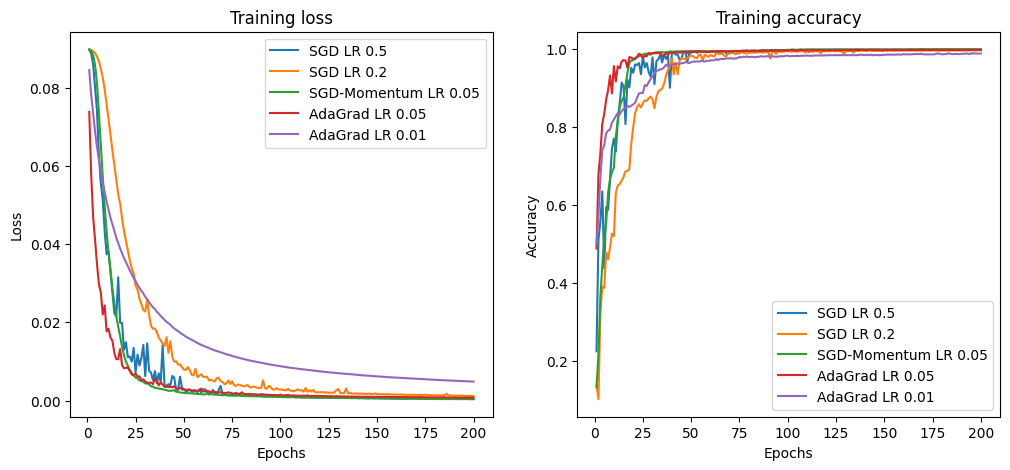

In [10]:
# Main function to run the experiments
def main():
    data = load_data()
    batch_size = 128
    input_size = 64  # For the digits dataset (8x8 images flattened)
    hidden_size = 20
    output_size = 10
    epochs = 200

    print("Training with SGD LR 0.5")
    network = NeuralNetwork(input_size, hidden_size, output_size)
    test_losses_sgd, test_accuracies_sgd = train(network, data, SGD(network.get_params_and_grads()[0], 0.5), epochs, batch_size)

    print("Training with SGD LR 0.2")
    network = NeuralNetwork(input_size, hidden_size, output_size)
    test_losses_sgd_b, test_accuracies_sgd_b = train(network, data, SGD(network.get_params_and_grads()[0], 0.2), epochs, batch_size)

    print("Training with SGD with Momentum LR 0.05")
    network = NeuralNetwork(input_size, hidden_size, output_size)
    test_losses_momentum, test_accuracies_momentum = train(network, data, SGD_Momentum(network.get_params_and_grads()[0], 0.05, 0.9), epochs, batch_size)

    print("Training with AdaGrad LR 0.05")
    network = NeuralNetwork(input_size, hidden_size, output_size)
    test_losses_adagrad, test_accuracies_adagrad = train(network, data, SGD_AdaGrad(network.get_params_and_grads()[0], 0.05, 1e-8), epochs, batch_size)

    print("Training with AdaGrad LR 0.01")
    network = NeuralNetwork(input_size, hidden_size, output_size)
    test_losses_adagrad_b, test_accuracies_adagrad_b = train(network, data, SGD_AdaGrad(network.get_params_and_grads()[0], 0.01, 1e-8), epochs, batch_size)

    # Compare train losses and train accuracies
    all_losses = [test_losses_sgd, test_losses_sgd_b, test_losses_momentum, test_losses_adagrad, test_losses_adagrad_b]
    all_accuracies = [test_accuracies_sgd, test_accuracies_sgd_b, test_accuracies_momentum, test_accuracies_adagrad, test_accuracies_adagrad_b]
    all_labels = ["SGD LR 0.5", "SGD LR 0.2", "SGD-Momentum LR 0.05", "AdaGrad LR 0.05", "AdaGrad LR 0.01"]
    plot_all_results(all_losses, all_accuracies, all_labels)

if __name__ == "__main__":
    main()

## 7. Increasing Layers

Instead of using 2-layer neural networks. We can increase number of layers to three and observe the loss again based on sgd. The newly added layer should adopt the same hidden size.

We are sticking to the same hyper-parameters as before.

* Plot the loss and accuracy.

* Discuss the impact of the increased layers in the pdf

In [11]:
# Please implement the 3-layer neural network and run the main function again to plot the curve.
# Neural network forward and backward propagation
class NeuralNetworkThreeLayer:
    def __init__(self, input_size, first_hidden_size, second_hidden_size, output_size):
        # Initialize weights and biases
        self.W1 = np.random.randn(input_size, first_hidden_size) * 0.01
        self.b1 = np.zeros((1, first_hidden_size))
        self.W2 = np.random.randn(first_hidden_size, second_hidden_size) * 0.01
        self.b2 = np.zeros((1, second_hidden_size))
        self.W3 = np.random.randn(second_hidden_size, output_size) * 0.01
        self.b3 = np.zeros((1, output_size))

        self.dW1 = np.zeros((input_size, first_hidden_size))
        self.db1 = np.zeros((1, first_hidden_size))
        self.dW2 = np.zeros((first_hidden_size, second_hidden_size))
        self.db2 = np.zeros((1, second_hidden_size))
        self.dW3 = np.zeros((second_hidden_size, output_size))
        self.db3 = np.zeros((1, output_size))

    # helper functions for our activations
    def sigmoid_derivative(self, x):
        y = self.sigmoid(x)
        return y * (1 - y)

    def sigmoid(self, x):
        return 1 / (1 + np.exp(-x))

    def softmax_derivative(self, x):
        y = self.softmax(x)
        
        def jac(row):
            sm = row.reshape((-1, 1))
            sm_dot = np.einsum('ij,jk->ik', sm, sm.T)
            return np.diagflat(row) - sm_dot
            
        d = np.apply_along_axis(jac, axis=1, arr=y)
        return d

    def softmax(self, x):
        exp_scores = np.exp(x - np.max(x, axis=1, keepdims=True))
        return exp_scores / np.sum(exp_scores, axis=1, keepdims=True)

    # forward and backward functions
    def forward(self, X):
        # Implement forward pass
        # You should store the intermediate values as fields to be used by the backward pass
        # The forward pass must work for all batch sizes

        # X: the x values, batched along dimension zero
        # return: z2

        self.a1 = np.dot(X, self.W1) + self.b1
        self.z1 = self.sigmoid(self.a1)
        self.a2 = np.dot(self.z1, self.W2) + self.b2
        self.z2 = self.sigmoid(self.a2)
        self.a3 = np.dot(self.z2, self.W3) + self.b3
        self.z3 = self.softmax(self.a3)
        return self.z3

    def backward(self, X, y):
        # Implement backward pass, assuming the MSE loss (see section 3 for clarification)
        # Use the intermediate values calculated from the forward pass,
        # and store the gradients in fields
        # The backward pass must also work for all batch sizes

        # X: the x values, batched along dimension zero
        # y: batched target values
        # return: None

        # output layer
        batch_size = X.shape[0]
        dz3 = (2 * (self.z3 - y) / batch_size)

        delta3 = np.einsum('Bi,BNi->BN', dz3, self.softmax_derivative(self.a3))
        self.dW3 = np.dot(self.z2.T, delta3)
        self.db3 = np.sum(delta3, axis=0, keepdims=True)

        # second hidden layer
        delta2 = np.dot(delta3, self.W3.T) * self.sigmoid_derivative(self.a2)
        self.dW2 = np.dot(self.z1.T, delta2)
        self.db2 = np.sum(delta2, axis=0, keepdims=True)

        # first hidden layer
        delta1 = np.dot(delta2, self.W2.T) * self.sigmoid_derivative(self.a1)
        self.dW1 = np.dot(X.T, delta1)
        self.db1 = np.sum(delta1, axis=0, keepdims=True)

    def get_params_and_grads(self):
        # Return parameters and corresponding gradients
        params = [self.W1, self.b1, self.W2, self.b2, self.W3, self.b3]
        grads = [self.dW1, self.db1, self.dW2, self.db2, self.dW3, self.db3]
        return params, grads

Training with SGD LR 0.5
Epoch 20/200, Loss: 0.0900, Accuracy: 0.1016
Epoch 40/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 60/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 80/200, Loss: 0.0900, Accuracy: 0.1002
Epoch 100/200, Loss: 0.0898, Accuracy: 0.1072
Epoch 120/200, Loss: 0.0833, Accuracy: 0.2129
Epoch 140/200, Loss: 0.0599, Accuracy: 0.5010
Epoch 160/200, Loss: 0.0482, Accuracy: 0.6548
Epoch 180/200, Loss: 0.0317, Accuracy: 0.8260
Epoch 200/200, Loss: 0.0164, Accuracy: 0.9541
Training with SGD LR 0.2
Epoch 20/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 40/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 60/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 80/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 100/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 120/200, Loss: 0.0900, Accuracy: 0.1350
Epoch 140/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 160/200, Loss: 0.0900, Accuracy: 0.1072
Epoch 180/200, Loss: 0.0899, Accuracy: 0.1037
Epoch 200/200, Loss: 0.0898, Accuracy: 0.1037
Training with SGD with Momentum LR 0.0

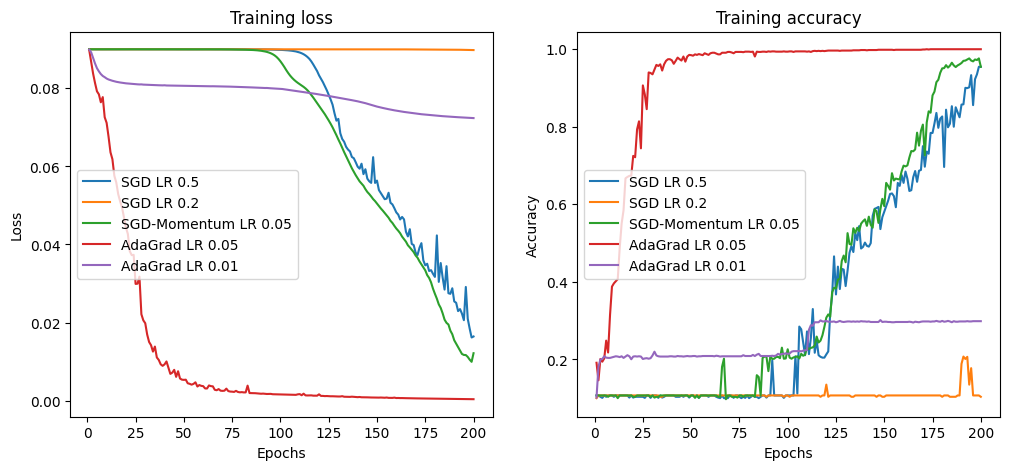

In [12]:
def test_third_layer_network():
    data = load_data()
    batch_size = 128
    input_size = 64  # For the digits dataset (8x8 images flattened)
    first_hidden_size = 20
    second_hidden_size = 20
    output_size = 10
    epochs = 200

    print("Training with SGD LR 0.5")
    network = NeuralNetworkThreeLayer(input_size, first_hidden_size, second_hidden_size, output_size)
    test_losses_sgd, test_accuracies_sgd = train(network, data, SGD(network.get_params_and_grads()[0], 0.5), epochs, batch_size)

    print("Training with SGD LR 0.2")
    network = NeuralNetworkThreeLayer(input_size, first_hidden_size, second_hidden_size, output_size)
    test_losses_sgd_b, test_accuracies_sgd_b = train(network, data, SGD(network.get_params_and_grads()[0], 0.2), epochs, batch_size)

    print("Training with SGD with Momentum LR 0.05")
    network = NeuralNetworkThreeLayer(input_size, first_hidden_size, second_hidden_size, output_size)
    test_losses_momentum, test_accuracies_momentum = train(network, data, SGD_Momentum(network.get_params_and_grads()[0], 0.05, 0.9), epochs, batch_size)

    print("Training with AdaGrad LR 0.05")
    network = NeuralNetworkThreeLayer(input_size, first_hidden_size, second_hidden_size, output_size)
    test_losses_adagrad, test_accuracies_adagrad = train(network, data, SGD_AdaGrad(network.get_params_and_grads()[0], 0.05, 1e-8), epochs, batch_size)

    print("Training with AdaGrad LR 0.01")
    network = NeuralNetworkThreeLayer(input_size, first_hidden_size, second_hidden_size, output_size)
    test_losses_adagrad_b, test_accuracies_adagrad_b = train(network, data, SGD_AdaGrad(network.get_params_and_grads()[0], 0.01, 1e-8), epochs, batch_size)

    # Compare train losses and train accuracies
    all_losses = [test_losses_sgd, test_losses_sgd_b, test_losses_momentum, test_losses_adagrad, test_losses_adagrad_b]
    all_accuracies = [test_accuracies_sgd, test_accuracies_sgd_b, test_accuracies_momentum, test_accuracies_adagrad, test_accuracies_adagrad_b]
    all_labels = ["SGD LR 0.5", "SGD LR 0.2", "SGD-Momentum LR 0.05", "AdaGrad LR 0.05", "AdaGrad LR 0.01"]
    plot_all_results(all_losses, all_accuracies, all_labels)

test_third_layer_network()